# Random Forest Regression Model Training
Testing the training of St Ebbes RF model.

In [1]:
# Python library imports
#------------------------
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import sys
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pickle
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import pytz

pd.plotting.register_matplotlib_converters()
# pd.set_option('display.max_colwidth', -1)

# File locations
#----------------
data_home = './oxaria/processed/'
rf_home = './oxaria/processed/models/methods_paper/'
pngs = './oxaria/pngs/


In [2]:
# Sensor data for colocated device at St Ebbes
#----------------------------------------------

df20 = pd.read_feather(data_home + 'batch_1_jan20_feb21/sebbes_train_536_s15_ratified.ftr').set_index(
    'rec').sort_index()

# Convert all float64 cols to float32
cols = df20.select_dtypes(np.float64).columns
df20[cols] = df20[cols].astype(np.float32)
print(df20['tag'].unique(), '\n')
df20.info(verbose=False)

# # Convert all float64 cols to float32
# cols = df21.select_dtypes(np.float64).columns
# df21[cols] = df21[cols].astype(np.float32)
# print(df21['tag'].unique(), '\n')
# df21.info(verbose=False)

sebbes_train_s15 = pd.concat([df20])
sebbes_train_s15['pm25_ugg_s'] = sebbes_train_s15['pm25_ugg_s']
sebbes_train_s15['pm25_ugg_s'] = np.where(
    sebbes_train_s15['pm25_ugg_s'] < 3.0, np.nan, sebbes_train_s15['pm25_ugg_s'])
print(sebbes_train_s15['tag'].unique(), '\n')
sebbes_train_s15.info(verbose=False)

['scs-bgx-538'] 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20160 entries, 2020-06-05 00:15:00+00:00 to 2021-01-01 00:00:00+00:00
Columns: 71 entries, tag to no2_ppb_h_bl
dtypes: float32(65), object(6)
memory usage: 6.1+ MB
['scs-bgx-538'] 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20160 entries, 2020-06-05 00:15:00+00:00 to 2021-01-01 00:00:00+00:00
Columns: 71 entries, tag to no2_ppb_h_bl
dtypes: float32(65), object(6)
memory usage: 6.1+ MB


In [3]:
# Update PM2.5 reference values
#-------------------------------
auto_merged = pd.read_feather(data_home+'batch_2_feb21_may21/auto_merged_ratified+2021_sept_update.ftr')
#auto_merged.info()

sebbes_train_s15 = sebbes_train_s15.merge(auto_merged[['rec','pm25_ugg_s']], left_on='rec', right_on='rec', how ='left')

sebbes_train_s15['pm25_ugg_s'] = sebbes_train_s15['pm25_ugg_s_y']
sebbes_train_s15.drop(columns=['pm25_ugg_s_x','pm25_ugg_s_y'], inplace=True)
sebbes_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20160 entries, 0 to 20159
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   rec                  20160 non-null  datetime64[ns, UTC]
 1   tag                  20160 non-null  object             
 2   val.no2.wev          20160 non-null  float32            
 3   val.no2.cnc          20160 non-null  float32            
 4   val.no2.aev          20160 non-null  float32            
 5   val.no2.wec          20160 non-null  float32            
 6   val.sht.hmd_g        20160 non-null  float32            
 7   val.sht.tmp_g        20160 non-null  float32            
 8   val.no2.cnc_1        19949 non-null  float32            
 9   name                 20160 non-null  object             
 10  val.hmd              20160 non-null  float32            
 11  val.tmp              20160 non-null  float32            
 12  val.mtf1          

In [4]:
# Function to generate the remaining feature required by the correction model
#-----------------------------------------------------------------------------

def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(
        axis=1, how='all').pct_change(periods=1)
    tmpdf1.columns = ['pc15_' + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(
        axis=1, how='all').pct_change(periods=2)
    tmpdf2.columns = ['pc30_' + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = df.merge(tmpdf1, left_index=True, right_index=True,
                  how='left').merge(tmpdf2,
                                    left_index=True,
                                    right_index=True,
                                    how='left').set_index(['tag', 'rec'])
    return df

def rushhour(df):
    # calc integer flags for hour of observation
    df['hour'] = df.index.get_level_values(1).hour
    # and day of week
    df['day'] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[(df.index.get_level_values(1).time >= dt.time(7, 30, 0)) &
           (df.index.get_level_values(1).time >= dt.time(9, 30, 0)) &
           (df.index.get_level_values(1).weekday < 5), 'rushhour'] = 1
    df.loc[(df.index.get_level_values(1).time >= dt.time(16, 0, 0)) &
           (df.index.get_level_values(1).time >= dt.time(18, 0, 0)) &
           (df.index.get_level_values(1).weekday < 5), 'rushhour'] = 2
    df['rushhour'] = np.where(df['rushhour'] >= 1, df['rushhour'],
                              0).astype(np.int32)
    return df

In [5]:
# Apply feature generation functions to St Ebbes training
#---------------------------------------------------------
tmp_list = []
for tag, dat in sebbes_train_s15.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
sebbes_train_s15_1 = pd.concat(tmp_list)
sebbes_train_s15_1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20160 entries, ('scs-bgx-538', Timestamp('2020-06-05 00:15:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-01-01 00:00:00+0000', tz='UTC'))
Data columns (total 200 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    index                     int64  
 1    val.no2.wev               float32
 2    val.no2.cnc               float32
 3    val.no2.aev               float32
 4    val.no2.wec               float32
 5    val.sht.hmd_g             float32
 6    val.sht.tmp_g             float32
 7    val.no2.cnc_1             float32
 8    name                      object 
 9    val.hmd                   float32
 10   val.tmp                   float32
 11   val.mtf1                  float32
 12   val.pm1                   float32
 13   val.mtf5                  float32
 14   val.pm2p5                 float32
 15   val.mtf3                  float32
 16   val.pm10                  float32
 17   va

In [6]:
# Constraing training to Jun to Nov, verification to Dec
# --------------------------------------------------------

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)

train_jun2nov = sebbes_train_s15_1.query('@jun <= rec < @dec').reset_index().set_index(['tag','rec'])

# Keep the interesting cols only, baseline & intermediate dfs
# confuse the training quite a bit, make sure to drop them
# ------------------------------------------------------------
train_df = train_jun2nov.loc[:, [
    'val.mtf1',
    'val.mtf5',
    'val.mtf3',
    'val.mtf7',
    'val.sfr',
    'val.hmd',
    'val.tmp',
    'pc15_val.mtf1',
    'pc15_val.mtf5',
    'pc15_val.mtf3',
    'pc15_val.mtf7',
    'pc15_val.sfr',
    'pc15_val.hmd',
    'pc15_val.tmp',
    'pc30_val.mtf1',
    'pc30_val.mtf5',
    'pc30_val.mtf3',
    'pc30_val.mtf7',
    'pc30_val.sfr',
    'pc30_val.hmd',
    'pc30_val.tmp',
    'hour',
    'day',
#     'pm25_ugg_s',
    'pm25_ugg_s',
#     'pm25_ugg_h',
#     'pm25_ugg_combo',
    'val.pm2p5_1_c1',
    'pc15_val.pm2p5_1_c1',
    'pc30_val.pm2p5_1_c1',
]]

# Drop weirdness in some columns
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
train_df.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13800 entries, ('scs-bgx-538', Timestamp('2020-06-05 00:45:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2020-11-30 23:45:00+0000', tz='UTC'))
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   val.mtf1             13800 non-null  float32
 1   val.mtf5             13800 non-null  float32
 2   val.mtf3             13800 non-null  float32
 3   val.mtf7             13800 non-null  float32
 4   val.sfr              13800 non-null  float32
 5   val.hmd              13800 non-null  float32
 6   val.tmp              13800 non-null  float32
 7   pc15_val.mtf1        13800 non-null  float32
 8   pc15_val.mtf5        13800 non-null  float32
 9   pc15_val.mtf3        13800 non-null  float32
 10  pc15_val.mtf7        13800 non-null  float32
 11  pc15_val.sfr         13800 non-null  float32
 12  pc15_val.hmd         13800 non-null  float32
 13  pc15_val.tmp  

In [7]:
# Define the training dataset. In this 1st cut using the full St Ebbes timeseries Jun-Nov
# ------------------------------------------------------------------------------------------

# Set training & target variables
X = train_df.drop(columns=[
    'pm25_ugg_s'
])  # remove target variable (i.e. no2) from training set.

y = train_df['pm25_ugg_s']  # define target variable (i.e. no2).

# Split into training & validation (test) datasets for both dependent & independent variables
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=7)


In [8]:
# Define a function to test model performance based on a range of max. no, of leaf node sizes
#---------------------------------------------------------------------------------------------
# The following function estimates mean absolute error as a metric for model
# accuracy.The number of trees used is set to 100 (i.e. n_estimators). 500 trees have also been tested but
# without any imporvement in accuracy so 100 is used to reduce training times.


def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):

    # Define the model
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes,
                                  random_state=7,
                                  n_estimators=100,
                                  n_jobs=-1)

    # Create a v simple pipeline that imputes missing input values before fitting the model to them
    #-----------------------------------------------------------------------------------------------
    my_pipeline = Pipeline(steps=[('preprocessor',
                                   SimpleImputer()), ('model', model)])

    # Calculate a metric variable using the cross_val_score function
    #----------------------------------------------------------------
    # The block below performs a cross validation excersise. For a given model configuration, it splits the
    # training set in 5 subsets and carries out a training sequence with the mean absolute error as a metric
    # of performance.
    # An avergae of those 5 MAE is then returned (see Figure below 'Validation' label).
    # This procedure ensures a robust training sequence as it removes the chance of
    # selecting a validation set that is very similar to the testing subset.
    #
    # Fit 5 random subsets of train_x & train_y to the pipeline RFR model & calc mean absolute error
    # multiply by -1 since sklearn calculates *negative* MAE
    metric = -1 * cross_val_score(
        my_pipeline, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')

    # Train the model
    my_pipeline.fit(train_X, train_y)

    # Predict dependent variable using validation & training subsets of independent variables
    preds_val = my_pipeline.predict(val_X)
    preds_tr = my_pipeline.predict(train_X)

    # MAE calculation for training and validation data
    mae_ver = mean_absolute_error(val_y, preds_val)
    mae_tr = mean_absolute_error(train_y, preds_tr)

    # Bring it all together in outputs
    return (mae_ver, mae_tr, metric.mean())


In [9]:
# Calculate model performance using MAE finction
#------------------------------------------------

# Initialise vars with range of nodes to test
mini = 100
maxi = 10000
step = 500

candidate_max_leaf_nodes = np.arange(mini, maxi, step).tolist()

# Loop using dict comprehension to find the ideal tree size from number of nodes tested.
# The following line calls the get_mae function above for
# every value of nodes defined in candiate_max_leaf_nodes.
scores = {
    leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y)
    for leaf_size in candidate_max_leaf_nodes
}
best_tree_size = min(scores, key=scores.get)


In [10]:
# Print leaf results
#--------------------
print(f'The best leaf node size between {mini} and {maxi} is:')
print(best_tree_size)
display(scores)


The best leaf node size between 100 and 10000 is:
4600


{100: (1.391367484426643, 1.2202063832028869, 1.398297151643068),
 600: (0.969928290162552, 0.5592567644500467, 1.0039186289749433),
 1100: (0.9108007576240862, 0.42318794017882233, 0.9607530229619767),
 1600: (0.8942156259399174, 0.37101805160391366, 0.951573843152878),
 2100: (0.8888472524276778, 0.34778255749640763, 0.9493307545909744),
 2600: (0.8870389690816776, 0.33693398600381413, 0.9486908456030221),
 3100: (0.886407960242692, 0.3314286145961625, 0.948443749407341),
 3600: (0.8860541549055557, 0.32872144272772785, 0.9484300478044739),
 4100: (0.8859900489015077, 0.32744865810698504, 0.9484112873782958),
 4600: (0.8859648958605941, 0.3268677839472323, 0.9484072410921544),
 5100: (0.8859748651906373, 0.32655022516934235, 0.9484072410921544),
 5600: (0.8859694752284581, 0.3264751863996764, 0.9484072410921544),
 6100: (0.8859694752284581, 0.3264751863996764, 0.9484072410921544),
 6600: (0.8859694752284581, 0.3264751863996764, 0.9484072410921544),
 7100: (0.8859694752284581, 0.32647

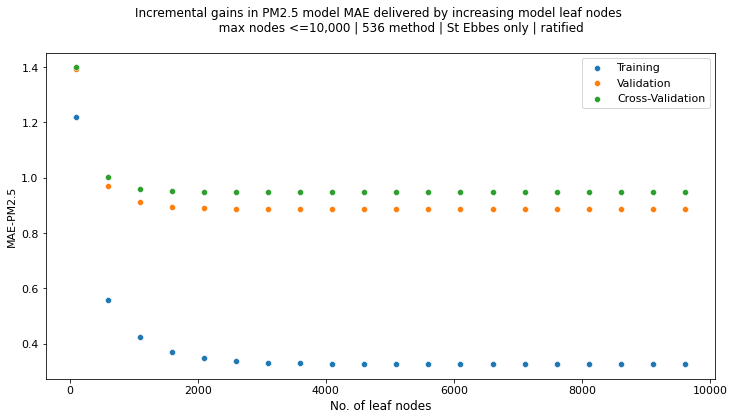

In [11]:
# Plot training & X validation results
#-------------------------------------
test = pd.DataFrame(scores)
plt.figure(figsize=(12, 6))

sns.scatterplot(x=test.columns,y=test.iloc[1], label='Training')
sns.scatterplot(x=test.columns,y=test.iloc[0], label='Validation')
sns.scatterplot(x=test.columns,y=test.iloc[2], label='Cross-Validation')

plt.ylabel('MAE-PM2.5',fontsize=11)
plt.xlabel('No. of leaf nodes',fontsize=12)
plt.title('Incremental gains in PM2.5 model MAE delivered by increasing model leaf nodes \n \
          max nodes <=10,000 | 536 method | St Ebbes only | ratified\n')
plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.show()

# Save figure if needed
#plt.savefig('training_results_pm10_mln10000_e100_536_ratified_mar_final.png',
#            dpi=300)

## Model training

In [12]:
# Redefine the model using best tree size & number
#--------------------------------------------------
model = RandomForestRegressor(max_leaf_nodes=3000,
                              random_state=7,
                              n_estimators=100,
                              n_jobs=-1)

# fit the model
model.fit(train_X, train_y)
model_prediction = model.predict(val_X)


# Validation results

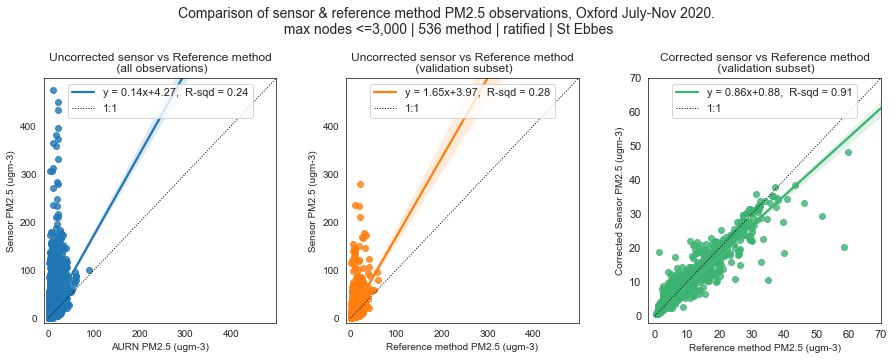

In [13]:
# Plot storyboard of model validation
#-------------------------------------

sns.set_style("white", {'axes.grid' : False})

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
fig.suptitle('Comparison of sensor & reference method PM2.5 observations, Oxford July-Nov 2020. \n \
max nodes <=3,000 | 536 method | ratified | St Ebbes \n', \
             y=1.1, \
             fontsize=14)

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

xlim = [0,1300]
axes[0].set_xlim(xlim)

# Get regression stats - sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    train_df['val.pm2p5_1_c1'], train_df['pm25_ugg_s'])
# Plot it
sns.regplot(x=train_df['pm25_ugg_s'],
            y=train_df['val.pm2p5_1_c1'],
            color='tab:blue',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[0],
            truncate=False)
axes[0].set(xlabel='AURN PM2.5 (ugm-3)',\
            ylabel='Sensor PM2.5 (ugm-3)',\
            title='Uncorrected sensor vs Reference method\n (all observations)',
            xlim=(-10,500),
            ylim=(-10,500),
            xticks=(np.arange(0,500,100)),
            yticks=(np.arange(0,500,100)))

one = [0, 100, 500]
sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1
            },
            scatter_kws={'s': 0},
            ax=axes[0],ci=None)

axes[1].set_xlim(xlim)

# Recalc regression stats - uncorrected validation subset sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, val_X['val.pm2p5_1_c1'])
# Plot it
sns.regplot(x=val_y,
            y=val_X['val.pm2p5_1_c1'],
            color='tab:orange',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[1],
            truncate=False)
axes[1].set(xlabel='Reference method PM2.5 (ugm-3)',
            ylabel='Sensor PM2.5 (ugm-3)',
            title='Uncorrected sensor vs Reference method\n (validation subset)',
            xlim=(-10,500),
            ylim=(-10,500),
            xticks=(np.arange(0,500,100)),
            yticks=(np.arange(0,500,100)))

one = [0, 100, 500]
sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1
            },
            scatter_kws={'s': 0},
            ax=axes[1],ci=None)

axes[2].set_xlim(0 ,100)

# # Recalc regression stats - corrected validation subset sensor vs reference method 
slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
sns.regplot(x=val_y,
            y=model_prediction,
            color='mediumseagreen',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[2],
            truncate=False)
axes[2].set(xlabel='Reference method PM2.5 (ugm-3)',
            ylabel='Corrected Sensor PM2.5 (ugm-3)',
            title='Corrected sensor vs Reference method\n (validation subset)',
            xlim=(-2,70),
            ylim=(-2,70),
            xticks=(np.arange(0,80,10)),
            yticks=(np.arange(0,80,10)))

one = [0, 10, 100]
sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1
            },
            scatter_kws={'s': 0},
            ax=axes[2],ci=None)

axes[0].legend(loc="upper center",fontsize=11)
axes[1].legend(loc="upper center",fontsize=11)
axes[2].legend(loc="upper center",fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.subplots_adjust(wspace=0.3)


##Save figure if needed.
fig.savefig('training_results_pm25_mln3000_e100_sebbes_356_ratified_mar_final.png', dpi=300)
plt.show()


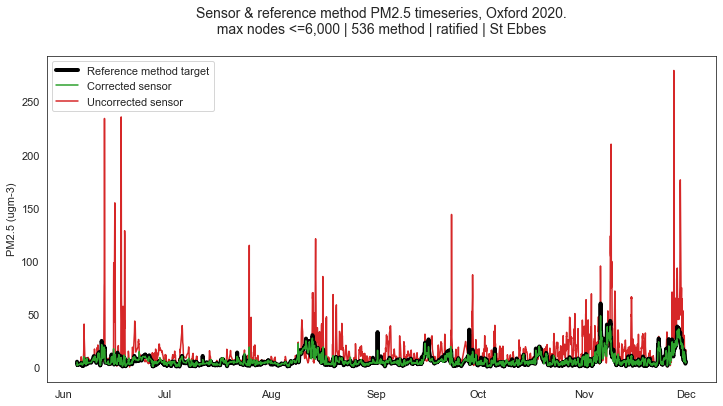

In [14]:
# Create a time series before & after, Jun to Nov
#------------------------------------------------
myFmt = mdates.DateFormatter('%b')

sns.set_style("white", {'axes.grid' : False})

# Model prediction
model_prediction = model.predict(val_X)

#Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=val_y.index.get_level_values(1),
                   y=val_y,
                   label='Reference method target',
                   color='k',
                   lw=4, zorder=2)
ax1 = sns.lineplot(x=val_y.index.get_level_values(1),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green', zorder=3)
ax1 = sns.lineplot(x=val_y.index.get_level_values(1),
                   y=val_X['val.pm2p5_1_c1'],
                   label='Uncorrected sensor',
                   color='tab:red', zorder=1)
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(myFmt)
#plt.ylim((-5, 80))
ax1.set_title('Sensor & reference method PM2.5 timeseries, Oxford 2020.\n \
max nodes <=6,000 | 536 method | ratified | St Ebbes \n', fontsize=14)
plt.ylabel('PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(loc='upper left',fontsize=11)
#plt.savefig(pngs + 'validation_results_pm10_mln6000_e100_sebbes_converging_356_ratified.png', dpi=300)
plt.show()

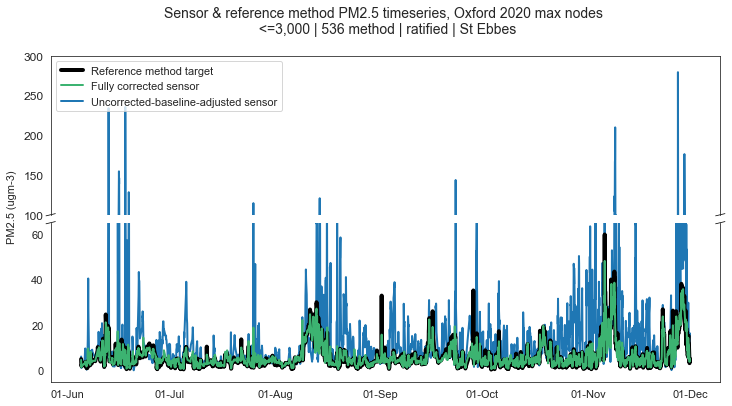

In [15]:
# Plotting the verification results using December 2020 data - split
# --------------------------------------------------------------------
sns.set_style("white", {'axes.grid': False})

myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(x=val_y.index.get_level_values(1),
             y=val_y,
             label='Reference method target',
             color='k',
             lw=4,
             zorder=2,
             ax=ax)
sns.lineplot(x=val_y.index.get_level_values(1),
             y=model_prediction,
             label='Fully corrected sensor',
             color='mediumseagreen',
             zorder=3,
             lw=2,
             ax=ax)
sns.lineplot(x=val_y.index.get_level_values(1),
             y=val_X['val.pm2p5_1_c1'],
             label='Uncorrected-baseline-adjusted sensor',
             color='tab:blue',
             zorder=1,
             lw=2,
             ax=ax)

sns.lineplot(x=val_y.index.get_level_values(1),
             y=val_y,
             color='k',
             lw=4,
             zorder=2,
             ax=ax2)
sns.lineplot(x=val_y.index.get_level_values(1),
             y=model_prediction,
             color='mediumseagreen',
             zorder=3,
             lw=2,
             ax=ax2)
sns.lineplot(x=val_y.index.get_level_values(1),
             y=val_X['val.pm2p5_1_c1'],
             color='tab:blue',
             zorder=1,
             lw=2,
             ax=ax2)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 300)  # outliers only
ax2.set_ylim(-5, 65)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = .007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Sensor & reference method PM2.5 timeseries, Oxford 2020 max nodes \n \
<=3,000 | 536 method | ratified | St Ebbes\n',
    fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.savefig('validation_results_pm25_mln3000_e100_split_356_ratified_split_mar_final.png',
            dpi=300)
plt.show()

# Parameter importance

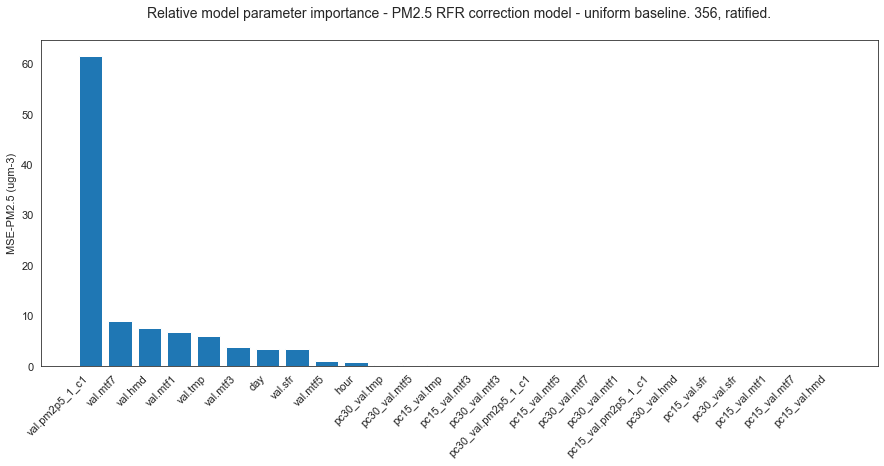

In [16]:
# Permutation importance is a method for determining how important a parameter is by sequentially 
#shuffling model parameters and measuring the effect on model accuracy (MAE in this case) 

# perform permutation importance
results = permutation_importance(model,train_X, train_y, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean
importance=pd.DataFrame(importance,index=train_X.columns, columns=['MSE'])
importance=importance.sort_values(by='MSE',ascending=False)

sns.set_style("white", {'axes.grid' : False})

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
plt.bar(importance.index,importance.MSE);
plt.ylabel('MSE-PM2.5 (ugm-3)', fontsize=11)
ax1.xaxis.set_tick_params(rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right', fontsize=12)
plt.title('Relative model parameter importance - PM2.5 RFR correction model - uniform baseline. 356, ratified.\n', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

#Save figure if needed
#plt.savefig(pngs+'parameter_importance_pm10_mln6000_e100_356_ratified.png', dpi=300)
plt.show()


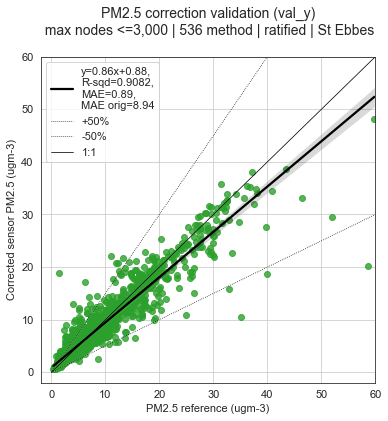

In [17]:
# Plot regression analysis of corrected verification sensor obs vs AURN
#-----------------------------------------------------------------------
sns.set_style("white", {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X['val.pm2p5_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='tab:green',
    line_kws={
        'label':
        'y={0:.2f}x+{1:.2f},\nR-sqd={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
        format(slope, intercept, r_value**2, mae_veri, mae_orig),
        'color':
        'k'
    })
ax2 = sns.regplot(x=one,
                  y=upper,
                  color='k',
                  line_kws={
                      'label': '+50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax3 = sns.regplot(x=one,
                  y=lower,
                  color='k',
                  line_kws={
                      'label': '-50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax4 = sns.regplot(x=one,
                  y=one,
                  color='k',
                  line_kws={
                      'label': '1:1',
                      'ls': '-',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax1.set_title('PM2.5 correction validation (val_y)\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes\n', fontsize=14)
ax1.set_xlim(-2, 60)
ax1.set_ylim(-2, 60)
ax1.set_xticks(np.arange(0, 70, 10))
ax1.set_yticks(np.arange(0, 70, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('PM2.5 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
#plt.savefig(pngs + 'verification_regression_pm10_mln3000_e100_356_ratified.png',
#            dpi=300)
plt.show()


In [18]:
# save the model to disk
filename = rf_home + 'RFR_model_pm25_mln3000_val_pm2p5_1_c2_mar_final.sav'
pickle.dump(model, open(filename, 'wb'))

In [19]:
# Read the saved model to avoid all the working above
#-----------------------------------------------------
model = pickle.load(open(rf_home + 'RFR_model_pm25_mln3000_val_pm2p5_1_c2_mar_final.sav', 'rb'))


In [20]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
#----------------------------------------------------------------------------
import csv

outfile = list(
    zip(val_y.index.get_level_values(1).values, val_y.values, model_prediction))

with open('values_for_cen_calc_3000_pm2p5_1_c2_mar_final.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ['datetime', 'pm25_ugg_s','val.pm25_1_c2'])
    csv_out.writerows(outfile)
    

In [21]:
# Print the  MAE stats for model configured with extra uniform backround time slots
#-----------------------------------------------------------------------------------
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X['val.pm2p5_1_c1'])

print('MAE in uncorrected verifiction data for Jun to Nov with uniform baseline: '+str(mae_orig))
print('MAE in corrected verifiction data for Jun to Nov with uniform baseline: '+str(mae_veri))
print('% 0.1f' % mae_orig,'% 0.1f' % mae_veri)

MAE in uncorrected verifiction data for Jun to Nov with uniform baseline: 8.940329
MAE in corrected verifiction data for Jun to Nov with uniform baseline: 0.8864846494391398
 8.9  0.9


In [22]:
# Doing verification with Dec unseen data with extra uniform backround time slots
#---------------------------------------------------------------------------------
dec = dt.datetime(2020,12,1,0,0,0,tzinfo=pytz.utc)
jan = dt.datetime(2021,1,1,0,0,0,tzinfo=pytz.utc)

df0 = sebbes_train_s15_1.query('@dec <= rec < @jan').reset_index().set_index(['tag','rec'])
val_df = pd.concat([df0]).sort_index()
val_df = val_df[~val_df.index.duplicated()]

# Get dec validation data
#-------------------------
validate_df = val_df.loc[:, [
    'val.mtf1',
    'val.mtf5',
    'val.mtf3',
    'val.mtf7',
    'val.sfr',
    'val.hmd',
    'val.tmp',
    'pc15_val.mtf1',
    'pc15_val.mtf5',
    'pc15_val.mtf3',
    'pc15_val.mtf7',
    'pc15_val.sfr',
    'pc15_val.hmd',
    'pc15_val.tmp',
    'pc30_val.mtf1',
    'pc30_val.mtf5',
    'pc30_val.mtf3',
    'pc30_val.mtf7',
    'pc30_val.sfr',
    'pc30_val.hmd',
    'pc30_val.tmp',
    'hour',
    'day',
    'pm25_ugg_s',
#     'pm25_ugg_h',
#     'pm25_ugg_combo',
    'val.pm2p5_1_c1',
    'pc15_val.pm2p5_1_c1',
    'pc30_val.pm2p5_1_c1',
]]

# Drop weirdness in some columns
validate_df = validate_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0).sort_index()
validate_df.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2955 entries, ('scs-bgx-538', Timestamp('2020-12-01 00:00:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2020-12-31 23:45:00+0000', tz='UTC'))
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   val.mtf1             2955 non-null   float64
 1   val.mtf5             2955 non-null   float64
 2   val.mtf3             2955 non-null   float64
 3   val.mtf7             2955 non-null   float64
 4   val.sfr              2955 non-null   float64
 5   val.hmd              2955 non-null   float64
 6   val.tmp              2955 non-null   float64
 7   pc15_val.mtf1        2955 non-null   float64
 8   pc15_val.mtf5        2955 non-null   float64
 9   pc15_val.mtf3        2955 non-null   float64
 10  pc15_val.mtf7        2955 non-null   float64
 11  pc15_val.sfr         2955 non-null   float64
 12  pc15_val.hmd         2955 non-null   float64
 13  pc15_val.tmp   

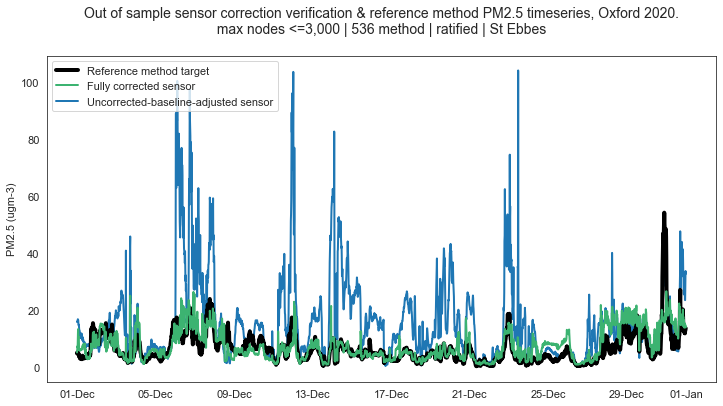

In [23]:
# Plotting the verification results using December 2020 data
#------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid': False})

df0 = validate_df.loc[:,'pm25_ugg_s']
df1 = validate_df.drop(columns=['pm25_ugg_s'])

# Model prediction
model_prediction = model.predict(df1)

# Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0.values,
                   label='Reference method target',
                   color='k',
                   lw=4,
                   zorder=2)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=model_prediction,
                   label='Fully corrected sensor',
                   color='mediumseagreen',
                   lw=2,
                   zorder=3)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=df1['val.pm2p5_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:blue',
                   lw=2,
                   zorder=1)

ax1.set_title('Out of sample sensor correction verification & reference method PM2.5 timeseries, Oxford 2020.\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes \n', fontsize=14)
ax1.xaxis.set_major_formatter(myFmt)
#plt.ylim((-5, 80))
plt.ylabel('PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11,loc='upper left')
plt.savefig('verification_results_pm25_mln3000_e100_sebbes_536_ratified_dec_mar_final.png', dpi=300)
plt.show()


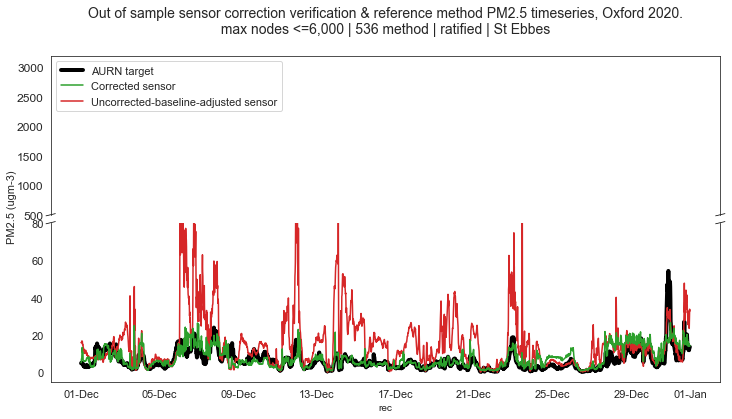

In [24]:
# Plotting the verification results using December 2020 data - split
# --------------------------------------------------------------------
sns.set_style("white", {'axes.grid': False})

myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# df = val_y.reset_index()

sns.lineplot(x=df0.index.get_level_values(1),
             y=df0.values,
             label='AURN target',
             color='k',
             lw=4,
             zorder=2,
             ax=ax)
sns.lineplot(x=df1.index.get_level_values(1),
             y=model_prediction,
             label='Corrected sensor',
             color='tab:green',
             zorder=3,
             ax=ax)
sns.lineplot(x=df1.index.get_level_values(1),
             y=df1['val.pm2p5_1_c1'],
             label='Uncorrected-baseline-adjusted sensor',
             color='tab:red',
             zorder=1,
             ax=ax)


sns.lineplot(x=df0.index.get_level_values(1),
             y=df0.values,
             color='k',
             lw=4,
             zorder=1,
             ax=ax2)
sns.lineplot(x=df1.index.get_level_values(1),
             y=model_prediction,
             color='tab:green',
             zorder=3,
             ax=ax2)
sns.lineplot(x=df1.index.get_level_values(1),
             y=df1['val.pm2p5_1_c1'],
             color='tab:red',
             zorder=2,
             ax=ax2)


# zoom-in / limit the view to different portions of the data
ax.set_ylim(500, 3200)  # outliers only
ax2.set_ylim(-5, 80)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = .007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('PM2.5 (ugm-3)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Out of sample sensor correction verification & reference method PM2.5 timeseries, Oxford 2020.\n \
max nodes <=6,000 | 536 method | ratified | St Ebbes \n',
    fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln3000_e100_sebbes_536_ratified_dec_split.png', dpi=300)
plt.show()

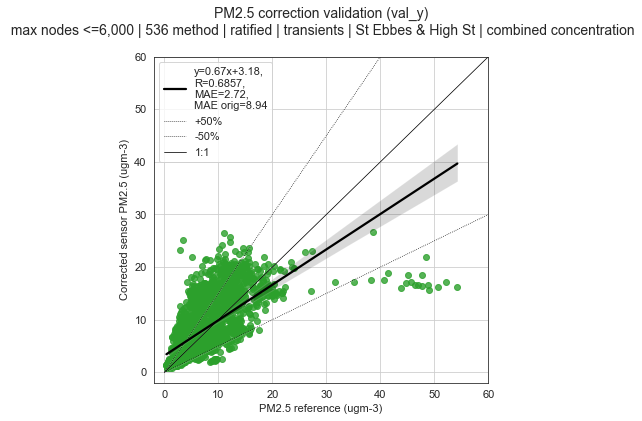

In [25]:
# Plot regression analysis of corrected verification sensor obs vs AURN
#-----------------------------------------------------------------------
sns.set_style("white", {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

# Model prediction
model_prediction = model.predict(df1)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    df0.values, model_prediction)
mae_veri = mean_absolute_error(df0.values, model_prediction)
#mae_orig = mean_absolute_error(val_y, val_X['val.pm2p5_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=df0.values,
    y=model_prediction,
    color='tab:green',
    line_kws={
        'label':
        'y={0:.2f}x+{1:.2f},\nR={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
        format(slope, intercept, r_value, mae_veri, mae_orig),
        'color':
        'k'
    },)
#    scatter_kws={'s': 2})
ax2 = sns.regplot(x=one,
                  y=upper,
                  color='k',
                  line_kws={
                      'label': '+50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax3 = sns.regplot(x=one,
                  y=lower,
                  color='k',
                  line_kws={
                      'label': '-50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax4 = sns.regplot(x=one,
                  y=one,
                  color='k',
                  line_kws={
                      'label': '1:1',
                      'ls': '-',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax1.set_title('PM2.5 correction validation (val_y)\n \
max nodes <=6,000 | 536 method | ratified | transients | St Ebbes & High St | combined concentration\n', fontsize=14)
ax1.set_xlim(-2, 60)
ax1.set_ylim(-2, 60)
ax1.set_xticks(np.arange(0, 65, 10))
ax1.set_yticks(np.arange(0, 65, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM2.5 (ugm-3)', fontsize=11)
plt.xlabel('PM2.5 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
#plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_combo.png',
#            dpi=300)
plt.show()


In [26]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
#----------------------------------------------------------------------------
import csv

outfile = list(
    zip(df0.index.get_level_values(1).values, df0.values, model_prediction))

with open('values_for_cen_calc_3000_pm2p5_1_c2_dec_mar_final.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ['datetime', 'pm25_ugg_s','val.pm2p5_1_c2'])
    csv_out.writerows(outfile)

mae_veri = mean_absolute_error(df0.values, model_prediction)
mae_orig = mean_absolute_error(df0.values, df1['val.pm2p5_1_c1'])

print('MAE in uncorrected verifiction data for December: '+str(mae_orig))
print('MAE in corrected verifiction data for December: '+str(mae_veri))
print('% 0.1f' % mae_orig,'% 0.1f' % mae_veri)

MAE in uncorrected verifiction data for December: 9.982779445727363
MAE in corrected verifiction data for December: 2.7242432198213407
 10.0  2.7


In [27]:
# # Doing verification with Dec unseen data with extra uniform backround time slots
# #---------------------------------------------------------------------------------
# jul = dt.datetime(2021,7,1,0,0,0,tzinfo=pytz.utc)
# dec = dt.datetime(2020,12,1,0,0,0,tzinfo=pytz.utc)

# df0 = sebbes_train_s15_1.query('@dec <= rec < @jul').reset_index().set_index(['tag','rec'])
# val_df = pd.concat([df0]).sort_index()
# val_df = val_df[~val_df.index.duplicated()]

# # Get dec validation data
# #-------------------------
# validate_df = val_df.loc[:, [
#     'val.mtf1',
#     'val.mtf5',
#     'val.mtf3',
#     'val.mtf7',
#     'val.sfr',
#     'val.hmd',
#     'val.tmp',
#     'pc15_val.mtf1',
#     'pc15_val.mtf5',
#     'pc15_val.mtf3',
#     'pc15_val.mtf7',
#     'pc15_val.sfr',
#     'pc15_val.hmd',
#     'pc15_val.tmp',
#     'pc30_val.mtf1',
#     'pc30_val.mtf5',
#     'pc30_val.mtf3',
#     'pc30_val.mtf7',
#     'pc30_val.sfr',
#     'pc30_val.hmd',
#     'pc30_val.tmp',
#     'hour',
#     'day',
#     'pm25_ugg_s',
# #     'pm25_ugg_h',
# #     'pm25_ugg_combo',
#     'val.pm2p5_1_c1',
#     'pc15_val.pm2p5_1_c1',
#     'pc30_val.pm2p5_1_c1',
# ]]

# # Drop weirdness in some columns
# validate_df = validate_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0).sort_index()
# validate_df.info()

In [28]:
# # Plotting the verification results using December 2020 data - split
# #--------------------------------------------------------------------

# # Model prediction
# df0 = validate_df.loc[:,'pm25_ugg_s']
# df1 = validate_df.drop(columns=['pm25_ugg_s'])
# model_prediction = model.predict(df1)

# sns.set_style("white", {'axes.grid' : False})

# myFmt = mdates.DateFormatter('%d-%b')

# f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))

# #df = val_y.reset_index()

# sns.lineplot(x=df0.index.get_level_values(1),
#                    y=df0.values,
#                    label='Reference method target (St Ebbes)',
#                    color='k',
#                    lw=4,
#                    zorder=2, ax=ax)

# sns.lineplot(x=df1.index.get_level_values(1),
#                    y=model_prediction,
#                    label='Corrected sensor',
#                    color='tab:green',
#                    zorder=3, ax=ax)
# sns.lineplot(x=df1.index.get_level_values(1),
#                    y=df1['val.pm2p5_1_c1'],
#                    label='Uncorrected-baseline-adjusted sensor',
#                    color='tab:red',
#                    zorder=1, ax=ax)


# sns.lineplot(x=df0.index.get_level_values(1),
#                    y=df0.values,
#                    color='k',
#                    lw=3,
#                    zorder=4, ax=ax2)
# sns.lineplot(x=df1.index.get_level_values(1),
#                    y=model_prediction,
#                    color='tab:green',
#                    lw=2,
#                    zorder=5, ax=ax2)
# sns.lineplot(x=df1.index.get_level_values(1),
#                    y=df1['val.pm2p5_1_c1'],
#                    color='tab:red',
#                    zorder=2, ax=ax2)


# # zoom-in / limit the view to different portions of the data
# ax.set_ylim(70,600)  # outliers only
# ax2.set_ylim(-5,60)  # most of the data

# # hide the spines between ax and ax2
# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax.xaxis.set_ticks_position('none')
# ax2.yaxis.set_label_coords(-0.05,1.1)
# ax.yaxis.label.set_visible(False)

# d = .007  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
# ax2.xaxis.set_major_formatter(myFmt)
# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# # What's cool about this is that now if we vary the distance between
# # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# # the diagonal lines will move accordingly, and stay right at the tips
# # of the spines they are 'breaking'

# f.subplots_adjust(hspace=0.05)

# plt.ylabel('PM2.5 (ugm-3)', fontsize=11)
# ax.legend(loc='upper left', fontsize=11)
# ax1.set_title('Out of sample sensor correction verification & reference method PM2.5 timeseries, Oxford 2020\n \
# max nodes <=6,000 | 536 method | ratified | St Ebbes & High St | combined concentration\n', fontsize=14)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)
# #plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split_combo.png', dpi=300)
# plt.show()


In [29]:
# # Plot regression analysis of corrected verification sensor obs vs AURN
# #-----------------------------------------------------------------------
# sns.set_style("white", {'axes.grid': True})

# one = [0, 20, 40, 60, 80, 100]
# upper = [i * 1.50 for i in one]
# lower = [i * 0.50 for i in one]

# # Model prediction
# model_prediction = model.predict(df1)

# slope, intercept, r_value, p_value, std_err = stats.linregress(
#     df0.values, model_prediction)
# mae_veri = mean_absolute_error(df0.values, model_prediction)
# #mae_orig = mean_absolute_error(val_y, val_X['val.pm2p5_1_c1'])

# fig = plt.figure(1, figsize=(6, 6))
# fig.add_subplot(111)
# ax1 = sns.regplot(
#     x=df0.values,
#     y=model_prediction,
#     color='tab:green',
#     line_kws={
#         'label':
#         'y={0:.2f}x+{1:.2f},\nR={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
#         format(slope, intercept, r_value, mae_veri, mae_orig),
#         'color':
#         'k'
#     },
#     scatter_kws={'s': 2})
# ax2 = sns.regplot(x=one,
#                   y=upper,
#                   color='k',
#                   line_kws={
#                       'label': '+50%',
#                       'ls': ':',
#                       'lw': 0.75
#                   },
#                   scatter_kws={'s': 0})

# ax3 = sns.regplot(x=one,
#                   y=lower,
#                   color='k',
#                   line_kws={
#                       'label': '-50%',
#                       'ls': ':',
#                       'lw': 0.75
#                   },
#                   scatter_kws={'s': 0})

# ax4 = sns.regplot(x=one,
#                   y=one,
#                   color='k',
#                   line_kws={
#                       'label': '1:1',
#                       'ls': '-',
#                       'lw': 0.75
#                   },
#                   scatter_kws={'s': 0})

# ax1.set_title('PM2.5 correction validation (val_y)\n \
# max nodes <=6,000 | 536 method | ratified | transients | St Ebbes & High St | combined concentration\n', fontsize=14)
# ax1.set_xlim(-2, 100)
# ax1.set_ylim(-2, 100)
# ax1.set_xticks(np.arange(0, 110, 10))
# ax1.set_yticks(np.arange(0, 110, 10))
# plt.legend(fontsize=11)
# plt.ylabel('Corrected sensor PM2.5 (ugm-3)', fontsize=11)
# plt.xlabel('PM2.5 reference (ugm-3)', fontsize=11)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)

# # Save figure if needed
# #plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_combo.png',
# #            dpi=300)
# plt.show()


In [30]:
# # Plot regression analysis of corrected verification sensor obs vs AURN
# #-----------------------------------------------------------------------
# sns.set_style("white", {'axes.grid': True})

# one = [0, 20, 40, 60, 80, 100]
# upper = [i * 1.50 for i in one]
# lower = [i * 0.50 for i in one]

# # Model prediction
# model_prediction = model.predict(df1)

# dftmp0 = pd.concat([
#     df0.reset_index(),
#     pd.DataFrame(model_prediction, columns=['model_prediction'])
# ],
#     axis=1).set_index(['tag', 'rec'])

# dftmp1 = dftmp0.groupby([
#     pd.Grouper(level='tag'),
#     pd.Grouper(level='rec',
#                freq='1H',
#                label='right',
#                convention='end',
#                origin='epoch')
# ]).mean()


# slope, intercept, r_value, p_value, std_err = stats.linregress(
#     dftmp1.iloc[:,0].values, dftmp1.iloc[:,1].values)
# mae_veri = mean_absolute_error(dftmp1.iloc[:,0].values, dftmp1.iloc[:,1].values)
# #mae_orig = mean_absolute_error(val_y, val_X['val.pm2p5_1_c1'])

# fig = plt.figure(1, figsize=(6, 6))
# fig.add_subplot(111)
# ax1 = sns.regplot(
#     x=dftmp1.iloc[:,0].values,
#     y=dftmp1.iloc[:,1].values,
#     color='tab:green',
#     line_kws={
#         'label':
#         'y={0:.2f}x+{1:.2f},\nR={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
#         format(slope, intercept, r_value, mae_veri, mae_orig),
#         'color':
#         'k'
#     },
#     scatter_kws={'s': 2})
# ax2 = sns.regplot(x=one,
#                   y=upper,
#                   color='k',
#                   line_kws={
#                       'label': '+50%',
#                       'ls': ':',
#                       'lw': 0.75
#                   },
#                   scatter_kws={'s': 0})

# ax3 = sns.regplot(x=one,
#                   y=lower,
#                   color='k',
#                   line_kws={
#                       'label': '-50%',
#                       'ls': ':',
#                       'lw': 0.75
#                   },
#                   scatter_kws={'s': 0})

# ax4 = sns.regplot(x=one,
#                   y=one,
#                   color='k',
#                   line_kws={
#                       'label': '1:1',
#                       'ls': '-',
#                       'lw': 0.75
#                   },
#                   scatter_kws={'s': 0})

# ax1.set_title('PM2.5 correction validation (val_y)\n \
# max nodes <=6,000 | 536 method | ratified | transients | St Ebbes & High St | combined concentration\n', fontsize=14)
# ax1.set_xlim(-2, 100)
# ax1.set_ylim(-2, 100)
# ax1.set_xticks(np.arange(0, 110, 10))
# ax1.set_yticks(np.arange(0, 110, 10))
# plt.legend(fontsize=11)
# plt.ylabel('Corrected sensor PM2.5 (ugm-3)', fontsize=11)
# plt.xlabel('PM2.5 reference (ugm-3)', fontsize=11)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)

# # Save figure if needed
# #plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_combo.png',
# #            dpi=300)
# plt.show()